In [1042]:
# импорт библиотек
import numpy as np
import pandas as pd 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from sklearn import datasets
iris = datasets.load_iris()

## 4 Оценка точности модели, переобучение, регуляризация
* закрепить знания о математическом смысле метрик `TPR`, `FPR`.
* Изучить построение `ROC-кривой`, графика `Precision-Recall`.

### Загрузка данных и преобразование в `DataFrame`

In [1043]:
df = pd.read_csv('../src/athletes.csv')

In [1044]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [1045]:
print(f"{str(len(df[pd.isnull(df['height'])]))} - Для `height` пустых строк")
print(f"{str(len(df[pd.isnull(df['weight'])]))} - Для `weight` пустых строк ")
print(f"{str(len(df[pd.isnull(df['sport'])]))} - Для `sport` пустых строк ")
print(f"{str(len(df))} - Всего строк в наборе ")

330 - Для `height` пустых строк
659 - Для `weight` пустых строк 
0 - Для `sport` пустых строк 
11538 - Всего строк в наборе 


In [1046]:
df = df[pd.isnull(df['height']) == 0]
df = df[pd.isnull(df['weight']) == 0]

In [1047]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


### Подготовка данных

In [1048]:
# убираем два поля которые не влияют на пол, в явном виде без дополнительного преобразования и целевую переменную sex
features_columns = [c for c in df.columns if c not in ['id', 'name', 'dob', 'sex']]
print("Признаки для модели: ", features_columns)

Признаки для модели:  ['nationality', 'height', 'weight', 'sport', 'gold', 'silver', 'bronze']


In [1049]:
# данный способ дает более высокий показатель score > 0.8
X = df[features_columns]
y = df['sex'].replace({'male':0, 'female':1})
X = pd.get_dummies(X, dtype=int)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
height,10858.0,1.766942,0.113111,1.21,1.69,1.76,1.84,2.21
weight,10858.0,72.070915,16.162358,31.00,60.00,70.00,81.00,170.00
gold,10858.0,0.059772,0.260756,0.00,0.00,0.00,0.00,5.00
silver,10858.0,0.058482,0.242387,0.00,0.00,0.00,0.00,2.00
bronze,10858.0,0.058574,0.239113,0.00,0.00,0.00,0.00,2.00
...,...,...,...,...,...,...,...,...
sport_tennis,10858.0,0.017591,0.131464,0.00,0.00,0.00,0.00,1.00
sport_triathlon,10858.0,0.010039,0.099694,0.00,0.00,0.00,0.00,1.00
sport_volleyball,10858.0,0.035181,0.184247,0.00,0.00,0.00,0.00,1.00
sport_weightlifting,10858.0,0.023761,0.152312,0.00,0.00,0.00,0.00,1.00


### Построение модели `LogisticRegression` train `80` / `20`

In [1050]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [1051]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [1052]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [1053]:
predictions = model.predict_proba(X_test)

In [1054]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8442320976283675, 0.8397790055248618)

### Оценка точности модели

#### Построение `ROC`-кривой с помощью функции `sklearn.metrics.roc_curve`

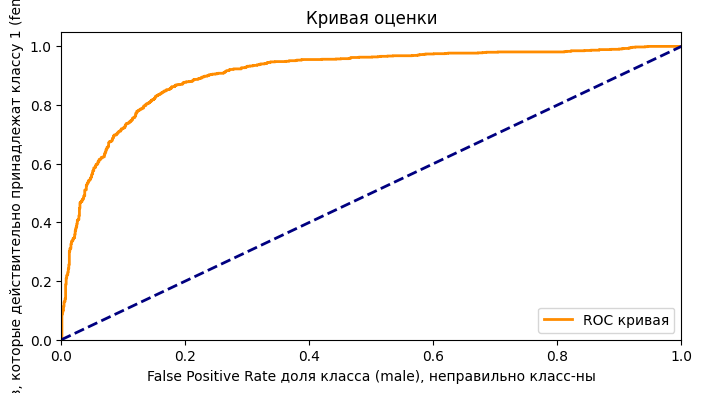

In [1055]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Предсказание вероятностей для класса 1 (положительный класс = female)
y_prob = model.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

#Построение ROC-кривой
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate доля класса (male), неправильно класс-ны')
plt.ylabel('TP (True Positives) - количество объектов, которые действительно принадлежат классу 1 (female) и были правильно класс-ны моделью')
plt.title('Кривая оценки')
plt.legend(loc='lower right')
plt.show()

#### Вычисление значение `ROC-AUC` метрики с помощью функции `sklearn.metrics.roc_auc_score`

In [1056]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC: {roc_auc:.2f}')

ROC-AUC: 0.90


#### Ручной подсчет метрик `TPR`, `FPR`, без использования готовых функций из библиотеки `sklearn`

In [1057]:
# сброс индексов для расчета
y_scores = model.predict_proba(X_test)[:, 1]
y_true = pd.Series(y_test).reset_index(drop=True)

In [1058]:
def calculate_tpr_fpr(y_true, y_prob, threshold=0.5, target_name=""):
    """
    Функция для вычисления True Positive Rate (TPR) и False Positive Rate (FPR) при заданном пороговом значении.
    Аргументы:
    - y_test: Истинные метки (1 - положительный класс, 0 - отрицательный класс).
    - y_prob: Вероятности принадлежности к положительному классу.
    - threshold: Пороговое значение для классификации (по умолчанию 0.5).
    Возвращает кортеж (TPR, FPR).
    """
    # Преобразование вероятностей в бинарные предсказания
    y_pred = (y_prob >= threshold).astype(int)

    # Вычисление True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FN = sum((y_true == 1) & (y_pred == 0))

    # Вычисление True Positive Rate (TPR) и False Positive Rate (FPR)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    # Вывод результатов с описанием
    print(f'Общее количество: {len(y_true)}, Порог: {threshold}')
    print(f'{TPR:.2f} = TPR (True Positive Rate, Recall) - доля верно распознанных `{target_name}` от общего количество данного класса | TP / (TP + FN) где: {TP} = TP (True Positives), {FN} FN (False Negatives)')
    print(f'{FPR:.2f} = FPR (False Positive Rate): доля ложных распознаваний `{target_name}` | {FP} = FP (False Positives), {TN} = TN (True Negatives)')
    return TPR, FPR


TPR, FPR = calculate_tpr_fpr(y_true, y_scores, threshold=0.5, target_name='female')

Общее количество: 2172, Порог: 0.5
0.84 = TPR (True Positive Rate, Recall) - доля верно распознанных `female` от общего количество данного класса | TP / (TP + FN) где: 845 = TP (True Positives), 159 FN (False Negatives)
0.16 = FPR (False Positive Rate): доля ложных распознаваний `female` | 189 = FP (False Positives), 979 = TN (True Negatives)


#### Ручной массива метрик `TPR`, `FPR`, для построения графика `ROC`, без использования готовых функций из библиотеки `sklearn`

In [1059]:
def my_calculate_roc_curve(y_true, y_scores):
    """
    Рассчитывает FPR и TPR для заданных истинных меток и вероятностей положительного класса.

    Параметры:
    - y_true: Массив истинных меток `sex` с бинарными значениями (0 и 1) female == 1.
    - y_scores: Массив вероятностей принадлежности к положительному классу female == 1.

    Возвращает:
    - fpr: Массив значений FPR.
    - tpr: Массив значений TPR.
    - precision: Массив значений precision
    - recall: Массив значений recall
    """
    # Инициализация списков для FPR и TPR
    fpr = []
    tpr = []

    # Инициализация списков для Precision и Recall
    precision = []
    recall = []

    # Создание массива порогов для оценок вероятности
    thresholds = sorted(set(y_scores), reverse=True)

    # Расчет FPR и TPR для каждого порога
    for thresh in thresholds:
        # Преобразование вероятностей в бинарные предсказания на основе порога
        y_pred = [1 if score >= thresh else 0 for score in y_scores]

        # Вычисление матрицы ошибок (Confusion Matrix)
        TP = sum((y_true[i] == 1) and (y_pred[i] == 1) for i in range(len(y_true)))
        FN = sum((y_true[i] == 1) and (y_pred[i] == 0) for i in range(len(y_true)))
        FP = sum((y_true[i] == 0) and (y_pred[i] == 1) for i in range(len(y_true)))
        TN = sum((y_true[i] == 0) and (y_pred[i] == 0) for i in range(len(y_true)))

        # Вычисление FPR и TPR
        curr_fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        curr_tpr = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Добавление значений FPR и TPR в списки
        fpr.append(curr_fpr)
        tpr.append(curr_tpr)

        # Вычисление Precision и Recall
        curr_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        curr_recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Добавление значений Precision и Recall в списки
        precision.append(curr_precision)
        recall.append(curr_recall)

    return fpr, tpr, precision, recall

FPR_my_calculate, TPR_my_calculate, precision_my_calculate, recall_my_calculate = my_calculate_roc_curve(y_true, y_scores)

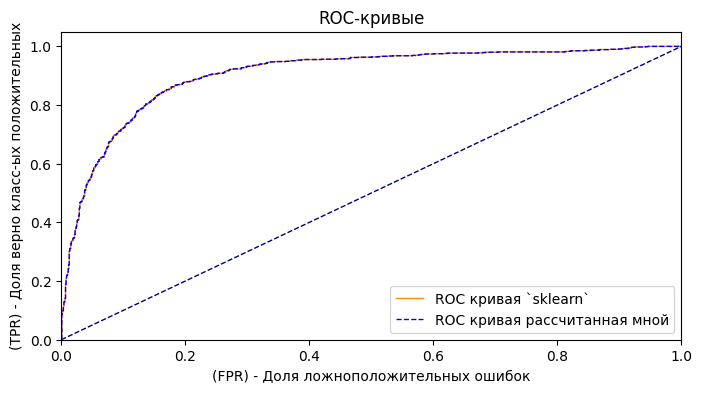

In [1060]:
# Построение ROC-кривых на одном графике
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC кривая `sklearn`')
plt.plot(FPR_my_calculate, TPR_my_calculate, color='blue', lw=1, linestyle='--', label='ROC кривая рассчитанная мной')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('(FPR) - Доля ложноположительных ошибок')
plt.ylabel('(TPR) - Доля верно класс-ых положительных')
plt.title('ROC-кривые')
plt.legend(loc='lower right')
plt.show()

#### Постройте график `Precision-Recall`, используя метрики, посчитанных вручную

In [1061]:
def show_precision_recall(recall, precision, title='Precision-Recall кривая'):
    # Построение графика Precision-Recall
    plt.figure(figsize=(8, 4))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall (Полнота)')
    plt.ylabel('Precision (Точность)')
    plt.title(title)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.show()

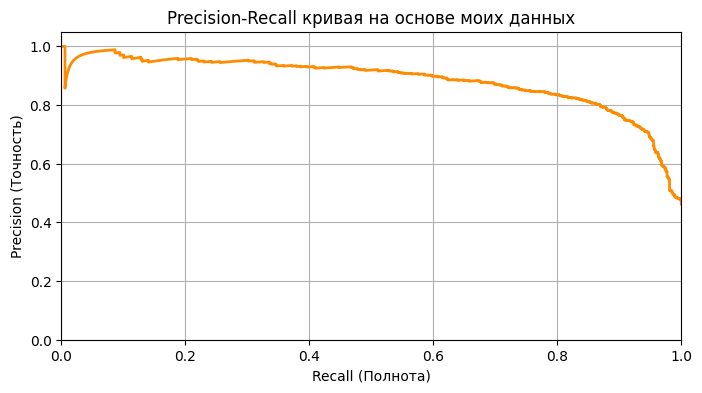

In [1062]:
# Вычисление значений точности и полноты
recall, precision = recall_my_calculate, precision_my_calculate
show_precision_recall(recall, precision, title='Precision-Recall кривая на основе моих данных')

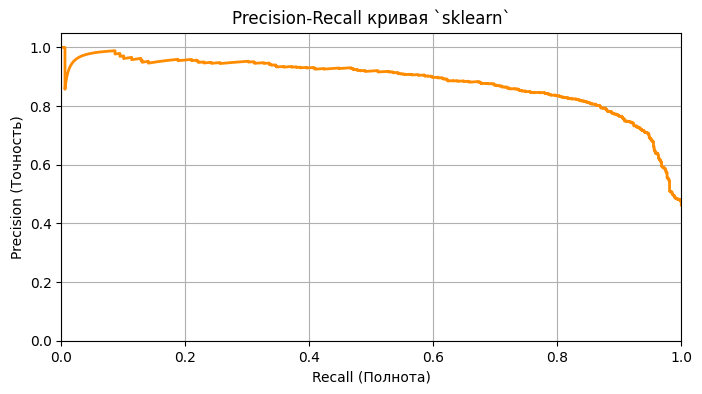

In [1063]:
from sklearn.metrics import precision_recall_curve

# Вычисление значений точности и полноты
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

show_precision_recall(recall, precision, title='Precision-Recall кривая `sklearn`')

In [1064]:
def calculate_roc_auc(fpr, tpr):
    """
    Рассчитывает ROC-AUC метрику на основе значений FPR и TPR.

    Параметры:
    - fpr: Массив значений False Positive Rate (FPR).
    - tpr: Массив значений True Positive Rate (TPR).

    Возвращает:
    - roc_auc: Значение ROC-AUC метрики.
    """
    # Проверка длины FPR и TPR
    if len(FPR_my_calculate) != len(TPR_my_calculate):
        print("Ошибка: Длины списков FPR и TPR не совпадают.")
    else:
        print("Длины списков FPR и TPR совпадают.")
    n = len(fpr)
    roc_auc = 0.0

    # Проверка диапазона значений FPR и TPR
    if any(value < 0 or value > 1 for value in FPR_my_calculate) or any(value < 0 or value > 1 for value in TPR_my_calculate):
        print("Ошибка: Значения FPR и TPR должны находиться в диапазоне от 0 до 1.")
    else:
        print("Значения FPR и TPR находятся в корректном диапазоне [0, 1].")

    for i in range(1, n):
        # Используем трапециевидное численное интегрирование
        roc_auc += (tpr[i] + tpr[i - 1]) * (fpr[i - 1] - fpr[i]) / 2

    return abs(roc_auc)

#### *Вычислите значение `ROC-AUC` метрики, используя метрики, посчитанные выше

In [1065]:
roc_auc_my_calculate = calculate_roc_auc(FPR_my_calculate, TPR_my_calculate)

# Вывести значение ROC-AUC
print(f"ROC-AUC (моя функция): {roc_auc_my_calculate:.2f}")

Длины списков FPR и TPR совпадают.
Значения FPR и TPR находятся в корректном диапазоне [0, 1].
ROC-AUC (моя функция): 0.90


In [1066]:
from sklearn.metrics import auc

# Вычислить ROC-AUC метрику
roc_auc_my_calculate = auc(FPR_my_calculate, TPR_my_calculate)

# Вывести значение ROC-AUC
print(f"ROC-AUC (sklearn): {roc_auc_my_calculate:.2f}")

ROC-AUC (sklearn): 0.90


### Выводы
* `score` = `0.83` указывает на хорошее качество модели;
* `0.84`= `TPR (True Positive Rate, Recall)`  Это доля верно распознанных женщин от общего количества данных этого класса;
* `0.16` = `FPR (False Positive Rate)`: доля ложных распознаваний женщин.  Это доля ложных положительных ошибок (ложных женщин 🙂), которых модель предсказала как женщин, но они на самом деле были мужчинами;
* `ROC` кривая посчитанная мной и готовой функцией из библиотеки совпадает, что говорит о корректности расчета, а так же выглядит не плохо (площадь под ней достаточна большая), что свидетельствует о качестве модели, идеальная кривая стремиться к левому верхнему углу;
* `Precision-Recall` графики совпадают и показывают важные характеристики производительности модели (охват и точность);
* `ROC-AUC` (моя функция): `0.90` говорит о том, что модель имеет хорошую способность различать классы;
* `ROC-AUC` `sklearn`: `0.90` Значение совпадает с моей функцией, что подтверждает корректность расчетов.